In [29]:
!pip install rawpy matplotlib
!pip install opencv-python


In [30]:
import rawpy

out_of_focus = r"C:\code\astrocam\outoffocus\Image741.nef"
in_focus = r"C:\code\astrocam\light\Image752.nef"
with open(out_of_focus, "rb") as f:
  rawimg = rawpy.imread(f)
  img = rawimg.postprocess()



In [31]:
img.shape

(2868, 4310, 3)

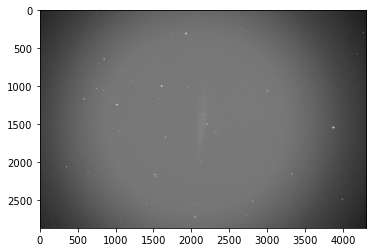

In [32]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [33]:
Bs = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(7,7))
Bmi = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
Be = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(25,25))
Bmo = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
d = (Bmo.shape[0] - Bmi.shape[0]) // 2
Bm = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
Bm[d:d+Bmi.shape[0], d:d+Bmi.shape[0]] -= Bmi


In [34]:
K = cv2.morphologyEx(gray, cv2.MORPH_OPEN, Bs)
N = cv2.morphologyEx(cv2.morphologyEx(gray, cv2.MORPH_DILATE, Bm), cv2.MORPH_ERODE, Be)
print(K.shape, N.shape)

(2868, 4310) (2868, 4310)


In [35]:
R = K -np.minimum(K,N)

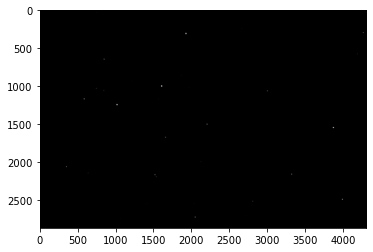

In [36]:
plt.imshow(R, cmap='gray')

In [37]:
numstars, labels, stats, centroids = cv2.connectedComponentsWithStats(R, 4, cv2.CV_16U, cv2.CCL_WU)

In [38]:
centroids

array([[2154.61204619, 1433.46232672],
       [ 749.5       ,   35.        ],
       [2658.70247934,  247.25619835],
       [2609.5       ,  250.5       ],
       [4260.50331126,  297.28476821],
       [1923.49      ,  308.10333333],
       [1733.5       ,  328.        ],
       [3803.        ,  349.        ],
       [4181.32142857,  577.33035714],
       [ 844.9       ,  645.47391304],
       [ 782.        ,  701.        ],
       [1862.61176471,  859.37647059],
       [1202.89873418,  931.91139241],
       [1603.36012862,  999.64630225],
       [1957.85      , 1019.89      ],
       [ 743.37168142, 1031.8539823 ],
       [ 840.69306931, 1058.63366337],
       [2997.54716981, 1063.03301887],
       [ 582.49193548, 1168.47177419],
       [1559.90410959, 1169.11643836],
       [1014.61290323, 1244.41935484],
       [2202.19762846, 1501.2687747 ],
       [3867.12109375, 1545.74609375],
       [1048.05147059, 1591.        ],
       [1654.        , 1674.64074074],
       [2592.57480315, 18

In [39]:
def getStar(staridx):
  centorid_x, centroid_y = centroids[staridx]
  width = stats[staridx, cv2.CC_STAT_WIDTH] / 2
  height = stats[staridx, cv2.CC_STAT_HEIGHT] / 2
  min_row = int(max(0, centroid_y - height))
  max_row = int(min(gray.shape[0], centroid_y + height+1))
  min_col = int(max(0, centorid_x - width))
  max_col = int(min(gray.shape[1], centorid_x + width+1))
  cell = gray[min_row:max_row, min_col:max_col]
  return cell

In [40]:
def plotStar3D(ax, star):
  xs = list(range(star.shape[1]))
  ys = list(range(star.shape[0]))
  xs, ys = np.meshgrid(xs, ys)
  X = np.arange(0, star.shape[1], 1)
  Y = np.arange(0, star.shape[0], 1)
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(xs, ys, star)

In [41]:
import scipy.optimize as opt

def twoD_GaussianScaledAmp(pos, xo, yo, sigma_x, sigma_y, amplitude, offset):
    """Function to fit, returns 2D gaussian function as 1D array"""
    x,y = pos
    xo = float(xo)
    yo = float(yo)    
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img, ax):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img = np.clip((img - bg) / (img.max() - bg),0,1)
    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), 
                               img.ravel(), p0=None, #initial_guess,
                               bounds = (
                                   (0.0, 0.0, 1, 1, 0.5, -0.1), # Lower bound
                                   (img.shape[1], img.shape[0], img.shape[1], img.shape[0], 1.5, 0.5) # Upper bound
                                )
                            )
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]

    z = offset + amp*np.exp( - (((x-xcenter)**2)/(2*sigmaX**2) + ((y-ycenter)**2)/(2*sigmaY**2)))
    ax.plot_surface(x,y,z)

    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y)



Num stars: 41
5.190433134317297 5.837999334529575


C:\Users\anand\AppData\Local\Temp\ipykernel_1948\1864966465.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5.393315846696101 5.7467481549082535
4.785336471798729 6.805688457960763
7.08733154091988 7.834038898638071
14.635621980607782 18.709070566175036
6.179658407419624 4.691879759872986
4.497592033997625 4.773161056126197
5.731365179637313 6.447955092394175
14.50503043619149 14.482711074382795
4.19776667108793 6.863652550688862
13.393014768040787 15.368847364346912
3.272717693820631 7.186872919403185
15.621462071002457 16.433509303562367
14.381929233024763 13.913016532398215
4.368223849976783 6.58883363079367
4.35039485717305 6.832120813721396
13.449502506239648 11.818339463003234
14.913058771791402 14.690202731338756
21.929377109191574 17.298329037293875
18.38392956421311 16.681178994597573
14.131787234165312 13.642332416295268
18.18858642109206 15.198346311025366
3.659576193359479 6.323709376457362


C:\Users\anand\AppData\Local\Temp\ipykernel_1948\1864966465.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


15.015422933498057 13.911841565403494
4.613699559564425 4.997137428956445
5.563806991344679 5.7867147233393466
14.365672218086726 12.762445132095467
8.150190777488904 9.812602395913226
6.012362949594201 6.35241280339755
11.996421737859155 9.925993535433703
15.346286434459534 13.910896416036774
8.642527213106478 5.628579989679669
5.759365421609469 6.140764852163121
8.400375699017946 9.028676848187422
11.020014525746602 10.99287493720783
6.862405919420332 4.575104039859875
6.277017228173968 4.411525559746638
5.245913143668171 4.580494687686173
13.06462521241152 15.016970940604343
6.888598355258858 4.649602998184586


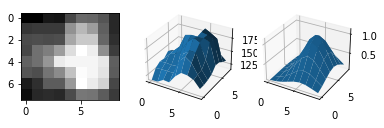

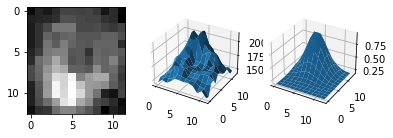

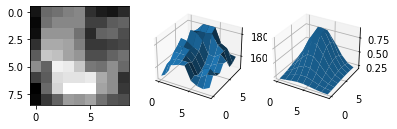

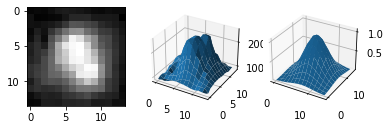

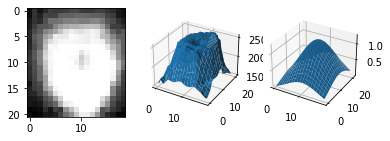

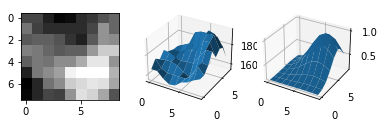

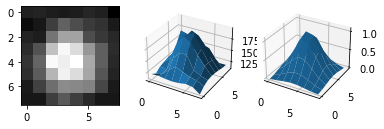

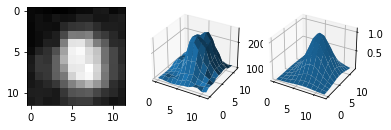

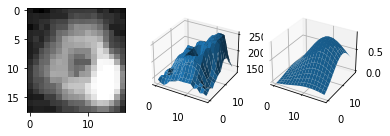

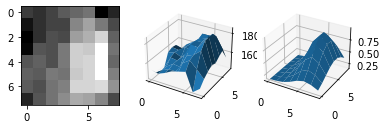

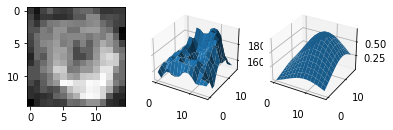

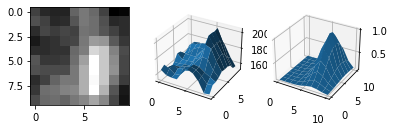

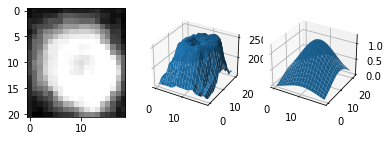

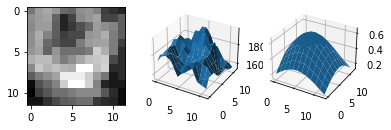

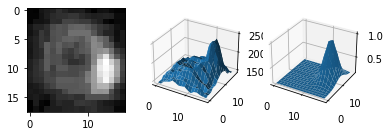

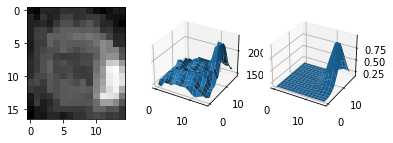

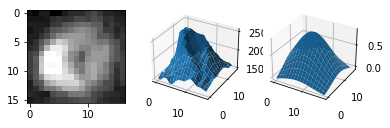

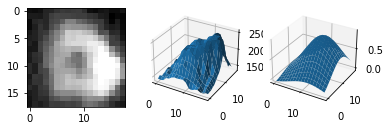

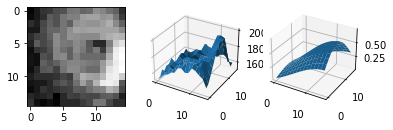

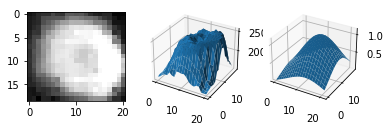

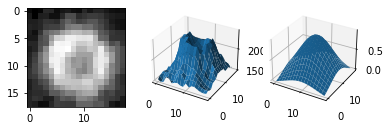

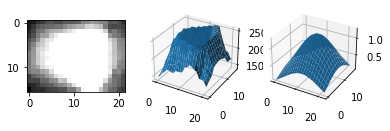

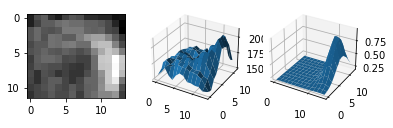

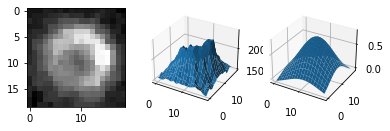

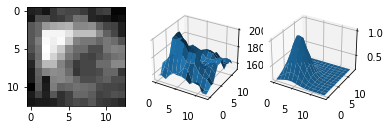

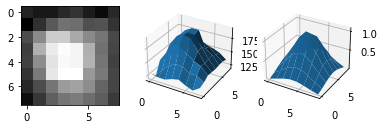

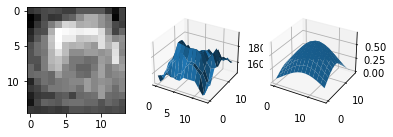

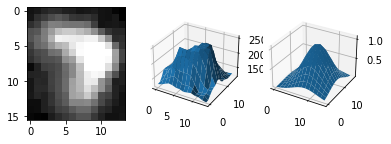

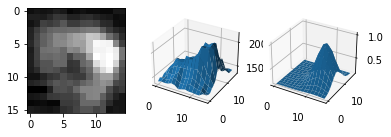

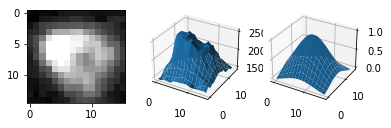

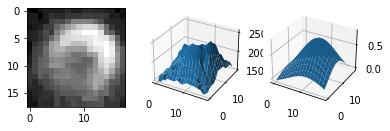

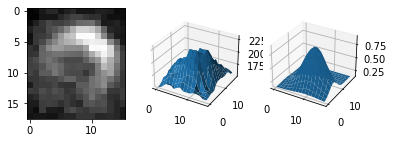

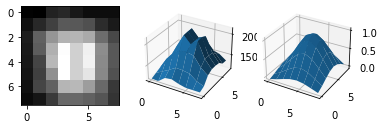

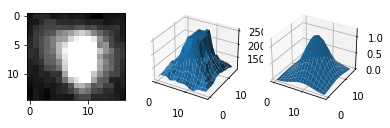

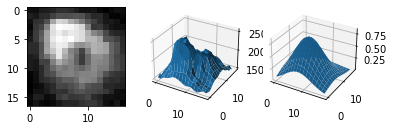

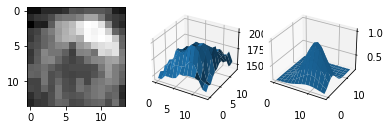

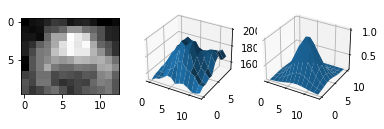

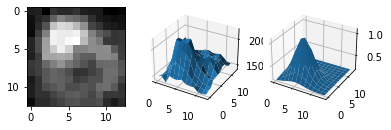

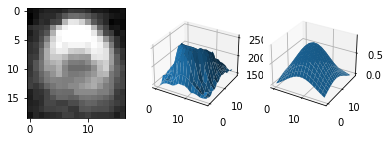

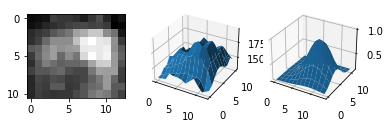

In [42]:
print(f"Num stars: {numstars}")
for staridx in range(1, numstars):
  star = getStar(staridx)

  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  ax.imshow(star, cmap='gray')

  ax = fig.add_subplot(1, 3, 2, projection='3d')
  plotStar3D(ax, star)

  ax = fig.add_subplot(1, 3, 3, projection='3d')
  FWHM_x, FWHM_y = getFWHM_GaussianFitScaledAmp(star, ax)
  print(FWHM_x, FWHM_y)
  fig.show()
  